In [1]:
# -*- coding: utf-8 -*- 

import numpy as np
import pandas as pd

from pathlib import Path

import nibabel as nib

import bids
from bids import BIDSLayout
from tqdm import tqdm

import nilearn as nil

import matplotlib.pyplot as plt

In [2]:
# information for path, hyperparams..
bids.config.set_option('extension_initial_dot', True)

In [4]:
params = {
     # need to changing your directory
    'data_dir': '/home/mybirth0407/datasets/ds000005',
#     'dm_model_path': '.models/ra_prospect_params_ms_mr.tsv'
    # model need to string form of model, which must in hbayesdm
    'dm_model': 'ra_prospect',
    'hrf_model': 'glover',
    'ncore': 4
}

In [5]:
def preprocess_events(params, df_events, df_events_info):
    for i in range(len(df_events)):
        df_events[i]['run'] = df_events_info[i]['run']
        df_events[i]['subjID'] = df_events_info[i]['subject']
        df_events[i]['gamble'] = df_events[i]['respcat'].apply(lambda x: 1 if x == 1 else 0)
        df_events[i]['cert'] = 0 # certain..?

In [6]:
def calculate_modulation(params, df_events, latent_params):
    # postprep
    for i in range(len(df_events)):
        idx = df_events[i].iloc[0]['subjID']
        df_events[i]['rho'] = latent_params.loc[idx]['rho']
        df_events[i]['lambda'] = latent_params.loc[idx]['lambda']
        df_events[i]['modulation'] = \
            (df_events[i]['gain'] ** df_events[i]['rho']) \
            - (df_events[i]['lambda'] * (df_events[i]['loss'] ** df_events[i]['rho']))

In [7]:
funcs = [preprocess_events, calculate_modulation]

In [8]:
def prepare_events(params, funcs):
    import hbayesdm.models
    from nilearn.glm.first_level.hemodynamic_models import compute_regressor
    from sklearn.preprocessing import minmax_scale

    layout = BIDSLayout(params['data_dir'], derivatives=True)
    t_r = layout.get_tr()
    events = layout.get(suffix='events', extension='tsv')
    image_sample = nib.load(
        layout.derivatives['fMRIPrep'].get(
            return_type='file',
            suffix='bold',
            extension='nii.gz')[0]
    )
    n_scans = image_sample.shape[-1]
    
    df_events_list = [event.get_df() for event in events]
    df_events_info = [event.get_entities() for event in events]
    
    if len(df_events_list) != len(df_events_info):
        assert()
    
    funcs[0](params, df_events_list, df_events_info)
    
    dm_model = getattr(hbayesdm.models, params['dm_model'])(
        data=pd.concat(df_events_list), ncore=params['ncore'])

    funcs[1](params, df_events_list, dm_model.all_ind_pars)
    
    frame_times = t_r * (np.arange(n_scans) + t_r/2)
    
    df_events = pd.concat(df_events_list)
    signals = []
    for name0, group0 in df_events.groupby(['subjID']):
        signal_subject = []
        for name1, group1 in df_events.groupby(['run']):
            exp_condition = np.array(group1[['onset', 'duration', 'modulation']]).T

            signal, name = compute_regressor(
                exp_condition=exp_condition,
                hrf_model=params['hrf_model'],
                frame_times=frame_times)
            signal_subject.append(signal)
        
        signal_subject = np.array(signal_subject)
        reshape_target = signal_subject.shape
        
        normalized_signal = minmax_scale(signal_subject.flatten(), axis=0, copy=True)
        normalized_signal = normalized_signal.reshape(reshape_target)
        signals.append(normalized_signal)

    return dm_model, df_events, np.array(signals)

In [9]:
a, b, c = prepare_events(params, funcs)

INFO:numexpr.utils:Note: detected 88 virtual cores but NumExpr set to maximum of 64, check "NUMEXPR_MAX_THREADS" environment variable.
INFO:numexpr.utils:Note: NumExpr detected 88 cores but "NUMEXPR_MAX_THREADS" not set, so enforcing safe limit of 8.
INFO:numexpr.utils:NumExpr defaulting to 8 threads.


Using cached StanModel: cached-ra_prospect-pystan_2.19.1.1.pkl



Model  = ra_prospect
Data   = <pandas.DataFrame object>

Details:
 # of chains                    = 4
 # of cores used                = 4
 # of MCMC samples (per chain)  = 4000
 # of burn-in samples           = 1000
 # of subjects                  = 16
 # of (max) trials per subject  = 256

Using cached StanModel: cached-ra_prospect-pystan_2.19.1.1.pkl
Index(['onset', 'duration', 'parametric loss', 'distance from indifference',
       'parametric gain', 'gain', 'loss', 'ptval', 'respnum', 'respcat',
       'responsetime', 'run', 'subjid', 'gamble', 'cert'],
      dtype='object')
['onset', 'duration', 'parametric loss', 'distance from indifference', 'parametric gain', 'gain', 'loss', 'PTval', 'respnum', 'respcat', 'response_time', 'run', 'subjID', 'gamble', 'cert']
************************************
**** Model fitting is complete! ****
************************************


In [10]:
c.shape

(16, 3, 240, 1)

In [11]:
c.min(), c.max(), c.mean()

(0.0, 1.0, 0.5015467327076711)

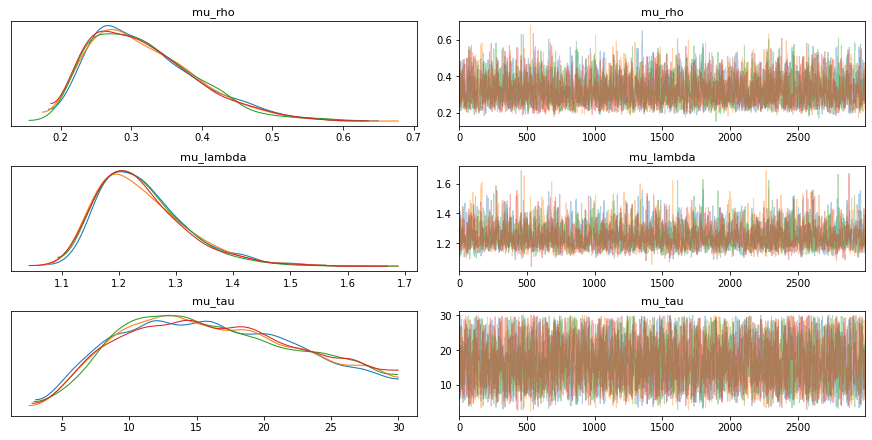

/home/mybirth0407/anaconda3/envs/mva/lib/python3.7/site-packages/arviz/utils.py:654: UserWarning: Keyword argument credible_interval has been deprecated Please replace with hdi_prob
  ("Keyword argument credible_interval has been deprecated " "Please replace with hdi_prob"),


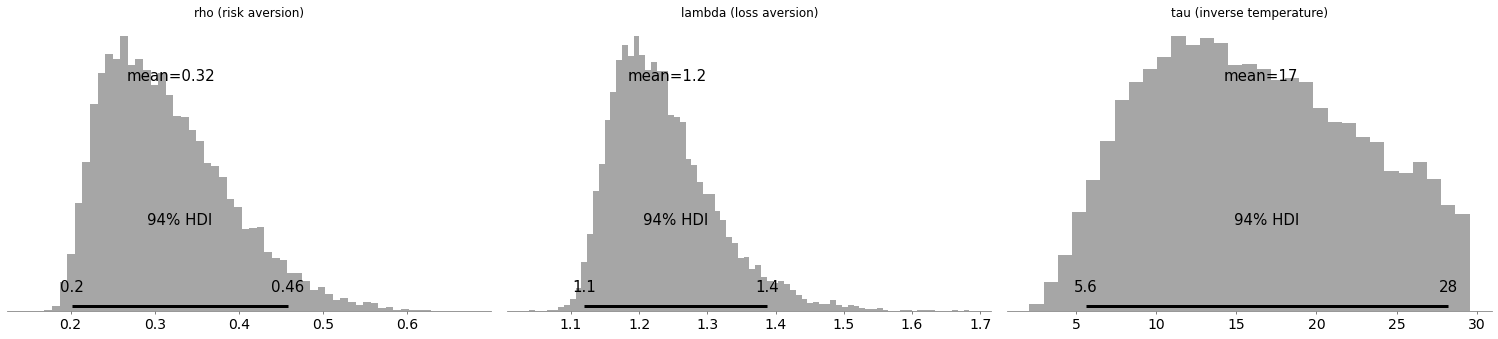

/home/mybirth0407/anaconda3/envs/mva/lib/python3.7/site-packages/arviz/stats/stats.py:151: UserWarning: 
The scale is now log by default. Use 'scale' argument or 'stats.ic_scale' rcParam if you rely on a specific value.
A higher log-score (or a lower deviance) indicates a model with better predictive accuracy.
  "\nThe scale is now log by default. Use 'scale' argument or "
/home/mybirth0407/anaconda3/envs/mva/lib/python3.7/site-packages/arviz/stats/stats.py:683: UserWarning: Estimated shape parameter of Pareto distribution is greater than 0.7 for one or more samples. You should consider using a more robust model, this is because importance sampling is less likely to work well if the marginal posterior and LOO posterior are very different. This is more likely to happen with a non-robust model and highly influential observations.
  "Estimated shape parameter of Pareto distribution is greater than 0.7 for "


,rank,loo,p_loo,d_loo,weight,se,dse,warning,loo_scale
ra_prospect,0,-1114.76,26.9203,0,1,100.708,0,True,log


In [12]:
from hbayesdm import rhat, print_fit

# Visually check convergence of the sampling chains (should look like "hairy caterpillars")
a.plot(type='trace')

# Plot posterior distributions of the hyper-parameters (distributions should be unimodal)
a.plot()

# Check Rhat values (all Rhat values should be less than or equal to 1.1)
rhat(a, less=1.1)

# Show the LOOIC and WAIC model fit estimates
print_fit(a)

In [14]:
import pickle
with open('modulation.pkl', 'wb') as f:
    pickle.dump(c, f, pickle.HIGHEST_PROTOCOL)

In [15]:
dir(a)

['_TaskModel__additional_args_desc',
 '_TaskModel__all_ind_pars',
 '_TaskModel__data_columns',
 '_TaskModel__fit',
 '_TaskModel__model',
 '_TaskModel__model_name',
 '_TaskModel__model_regressor',
 '_TaskModel__model_type',
 '_TaskModel__par_vals',
 '_TaskModel__parameters',
 '_TaskModel__parameters_desc',
 '_TaskModel__postpreds',
 '_TaskModel__raw_data',
 '_TaskModel__regressors',
 '_TaskModel__task_name',
 '__abstractmethods__',
 '__class__',
 '__delattr__',
 '__dict__',
 '__dir__',
 '__doc__',
 '__eq__',
 '__format__',
 '__ge__',
 '__getattribute__',
 '__gt__',
 '__hash__',
 '__init__',
 '__init_subclass__',
 '__le__',
 '__lt__',
 '__module__',
 '__ne__',
 '__new__',
 '__reduce__',
 '__reduce_ex__',
 '__repr__',
 '__setattr__',
 '__sizeof__',
 '__str__',
 '__subclasshook__',
 '__weakref__',
 '_abc_impl',
 '_check_data_columns',
 '_check_missing_values',
 '_check_postpred',
 '_check_regressor',
 '_define_measure_function',
 '_designate_stan_model',
 '_extract_from_fit',
 '_extract_mo

In [20]:
a.par_vals['mu_rho'].shape

(12000,)